In [ ]:
#Sawit Rerkyindee

# Competition ; predict water pump function
* https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/
* https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/#labels_list

* Type of question : Node classification
* Algorithm : Graph Convolutional network
 * https://www.experoinc.com/post/node-classification-by-graph-convolutional-network

# Steps
## 1. Import 
## 2. Imputation
## 3. Modelling
* 3.1. Create data for GNN
 *  InMemoryDataset, https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html
* 3.2. Build a GNN
 * Net, https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
 * Massage passing, https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
* 3.3. Train model
* 3.4. Validation
* 3.5. Result

In [475]:
import numpy as np
import pandas as pd
import pickle
import csv
import os
import random
from sklearn import metrics
from collections import defaultdict 
from tqdm import tqdm
import statistics 
from math import sqrt
from tqdm.notebook import tqdm
from scipy import stats

# Vis
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
import seaborn as sns

# Imputing
from geopy.geocoders import Nominatim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#import torch
#from torch_geometric.data import Data

# Load dataset

In [2]:
train_label = pd.read_csv('training_set_labels.csv')
train_value = pd.read_csv('training_set_values.csv')
test_value = pd.read_csv('test_set_values.csv')

In [3]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train_value)
dataset =  pd.concat(objs=[train_value, test_value], axis=0).reset_index(drop=True)

# Explore data

In [5]:
Ser1=dataset.nunique()
Ser1.sort_values()

recorded_by                  1
permit                       2
public_meeting               2
source_class                 3
quantity_group               5
quantity                     5
management_group             5
quality_group                6
waterpoint_type_group        6
source_type                  7
payment_type                 7
payment                      7
waterpoint_type              7
extraction_type_class        7
water_quality                8
basin                        9
source                      10
scheme_management           12
management                  12
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 68
amount_tsh                 102
lga                        125
date_recorded              369
population                1128
ward                      2098
funder                    2140
installe

# Data imputation

# cleanning data

In [45]:
# Preparing data which will be imputed by KNN cluster laster
dataset = dataset.replace('none', 'Unknown')
# Replacing NA with 'Unknown'
dataset['funder'] = dataset['funder'].fillna('Unknown')
dataset['installer'] = dataset['installer'].fillna('Unknown')
dataset['subvillage'] = dataset['subvillage'].fillna('Unknown')
dataset['scheme_name'] = dataset['scheme_name'].fillna('Unknown')
dataset['scheme_management'] = dataset['scheme_management'].fillna('Unknown')
dataset['public_meeting'] = dataset['public_meeting'].fillna('Unknown')
dataset['permit'] = dataset['permit'].fillna('Unknown')

In [46]:
# check any NA in dataset
dataset.apply(lambda x: sum(x.isnull()))

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
subvillage               0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
s

# Cleanning data

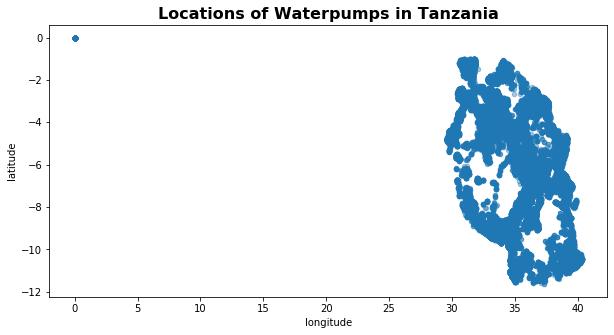

In [22]:
dataset.plot(kind='scatter', x="longitude", y="latitude", alpha=0.4, figsize=(10,5));
plt.title("Locations of Waterpumps in Tanzania", fontsize =16, fontweight='bold')
plt.legend;

In [23]:
dataset.loc[(dataset['longitude']<20)&(dataset['latitude']>-3),'lga'].unique()

array(['Bariadi', 'Geita', 'Magu'], dtype=object)

In [24]:
#geocode cannot find Magu
dataset['lga'] = dataset['lga'].replace('Magu', 'Magu Tanzania')

#Fix missing latlong
for lga in dataset[(dataset.latitude == -2.000000e-08) | (dataset.longitude == 0)]['lga'].unique():
    geolocator = Nominatim()
    location = geolocator.geocode(lga)
    dataset.loc[dataset.lga == lga, 'latitude'] = location.latitude
    dataset.loc[dataset.lga == lga, 'longitude'] = location.longitude    

/Users/sawit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


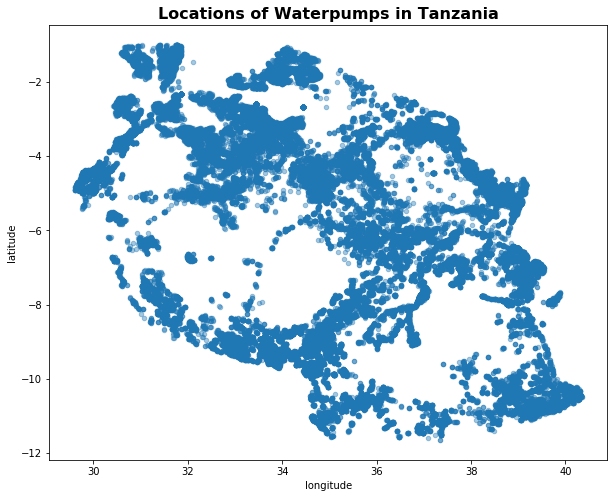

In [25]:
dataset.plot(kind='scatter', x="longitude", y="latitude", alpha=0.4, figsize=(10,8));
plt.title("Locations of Waterpumps in Tanzania", fontsize =16, fontweight='bold')
plt.legend;

# fix gps_height

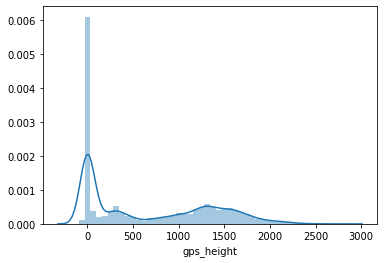

In [26]:
x=dataset['gps_height']
sns.distplot(x)

In [27]:
hh = pd.read_csv('heights.csv')

In [28]:
hhh = pd.merge(dataset,hh,on='id',how='left')

In [29]:
dataset['gps_height'] = hhh["gps_height_y"].fillna(hhh["gps_height_x"])

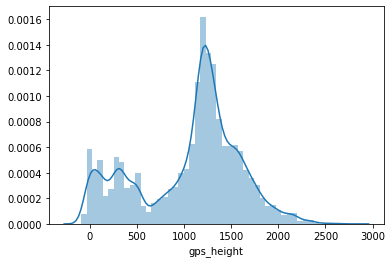

In [30]:
x=dataset['gps_height']
sns.distplot(x)

In [31]:
Ser1=dataset.nunique()
Ser1.sort_values()

recorded_by                  1
source_class                 3
permit                       3
public_meeting               3
quantity_group               5
quantity                     5
management_group             5
quality_group                6
waterpoint_type_group        6
source_type                  7
payment_type                 7
payment                      7
waterpoint_type              7
extraction_type_class        7
water_quality                8
basin                        9
source                      10
management                  12
scheme_management           13
extraction_type_group       13
extraction_type             18
district_code               20
region                      21
region_code                 27
construction_year           55
num_private                 68
amount_tsh                 102
lga                        125
date_recorded              369
population                1128
ward                      2098
funder                    2140
installe

In [32]:
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'Unknown') if x.name=='wpt_name' else x)
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'Unknown') if x.name=='subvillage' else x)
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<200, 'Unknown') if x.name=='scheme_name' else x)
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<500, 'Unknown') if x.name=='installer' else x)
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<700, 'Unknown') if x.name=='funder' else x)
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<150, 'Unknown') if x.name=='ward' else x)
dataset = dataset.apply(lambda x: x.mask(x.map(x.value_counts())<850, 'Unknown') if x.name=='lga' else x)

# Feature engineer
* https://github.com/huytofu/huytofu.ML_Projects/blob/content/Water%20Pump%20Status%20Predictions/Model_Submission.ipynb
* https://github.com/ksdkalluri/identifying_faulty_pumps/blob/master/Data_Cleaning_and_Exploratory_analysis.ipynb

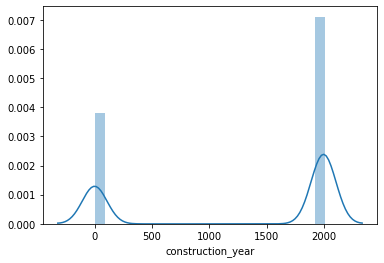

In [33]:
x=dataset['construction_year']
sns.distplot(x)

In [34]:
mean_year = dataset[dataset['construction_year']>0]['construction_year'].mean()
print(int(mean_year))
dataset['construction_year'] = dataset['construction_year'].replace({0:int(mean_year)})

dataset['pump_age'] = pd.DatetimeIndex(dataset['date_recorded']).year - dataset['construction_year']
dataset.loc[dataset['pump_age'] < 0,['pump_age']] = 0

1996


# Data reduction
### there are some features that have similarity
* "recorded_by" only have one value >> remove

* quantity_group & quantity >> quantity_group
* payment & payment_type >> payment_type
* water_quality & quality group > water_quality
* source, source_type & source class >> source_type
* waterpoint_type & waterpoint_type_group >> waterpoint_type
* scheme_management & management_group >> scheme_management
* extraction_type, extraction_type_group & extraction_type_class >> extraction_type 

In [35]:
df_vis = pd.merge(dataset,train_label,on='id')

In [36]:
from scipy.stats import chi2_contingency

def check_chi(df,col1):
    pivot = pd.crosstab(df[col1], df.status_group, margins=True)
    observed = pivot.iloc[:-1, :-1]
    expected =  np.outer(pivot["All"][:-1],pivot.loc["All"][:-1])
    chi2, p, dof, ex = chi2_contingency(observed, correction=False)
    print (col1,'|Chi result: pvalue',p,',chi2',chi2)

In [37]:
# picked quantity
check_chi(df_vis,'quantity_group')
check_chi(df_vis,'quantity')

# Picked management
check_chi(df_vis,'scheme_management')
check_chi(df_vis,'management_group')
check_chi(df_vis,'management')

#picked water_quality 
check_chi(df_vis,'water_quality')
check_chi(df_vis,'quality_group')

# picked payment_type
check_chi(df_vis,'payment')
check_chi(df_vis,'payment_type')

# Picked source
check_chi(df_vis,'source')
check_chi(df_vis,'source_type')
check_chi(df_vis,'source_class')

# waterpoint_type
check_chi(df_vis,'waterpoint_type')
check_chi(df_vis,'waterpoint_type_group')

# extraction_type
check_chi(df_vis,'extraction_type')
check_chi(df_vis,'extraction_type_group')
check_chi(df_vis,'extraction_type_class')

# region
check_chi(df_vis,'region')
check_chi(df_vis,'region_code')
check_chi(df_vis,'district_code')

quantity_group |Chi result: pvalue 0.0 ,chi2 11360.767895852761
quantity |Chi result: pvalue 0.0 ,chi2 11360.767895852761
scheme_management |Chi result: pvalue 0.0 ,chi2 1991.0656344682761
management_group |Chi result: pvalue 1.744626138526002e-57 ,chi2 287.65157783580787
management |Chi result: pvalue 0.0 ,chi2 2081.1263983553317
water_quality |Chi result: pvalue 0.0 ,chi2 2277.37334278519
quality_group |Chi result: pvalue 0.0 ,chi2 2100.1365875688944
payment |Chi result: pvalue 0.0 ,chi2 3965.6194039747866
payment_type |Chi result: pvalue 0.0 ,chi2 3965.619403974787
source |Chi result: pvalue 0.0 ,chi2 2623.998280150263
source_type |Chi result: pvalue 0.0 ,chi2 1906.7974141394534
source_class |Chi result: pvalue 1.983538119535752e-126 ,chi2 590.263287271222
waterpoint_type |Chi result: pvalue 0.0 ,chi2 7450.316596608293
waterpoint_type_group |Chi result: pvalue 0.0 ,chi2 6114.774218320656
extraction_type |Chi result: pvalue 0.0 ,chi2 7365.638497624808
extraction_type_group |Chi resul

In [38]:
# drop some column
dataset_imputed = dataset.drop(columns=['recorded_by','date_recorded'
                                 ,'region_code','district_code','construction_year'
                                 ,'scheme_management','management_group'
                                 ,'quality_group'
                                 ,'payment'
                                 ,'source_type','source_class'
                                 ,'waterpoint_type_group'
                                 ,'extraction_type_group','extraction_type_class'
                                 ]) 

In [39]:
#transform these features into one_hot format (0 and 1 for each value which now each is a column)
dataset_imputed = pd.get_dummies(dataset_imputed)

In [40]:
dataset_imputed.shape

(74250, 296)

In [25]:
dataset_imputed.to_csv('{}.csv'.format('dataset_imputed'),index=False)

# amount_tsh

mean of amount_tsh by status_group
functional                 461.798235
functional needs repair    267.071577
non functional             123.481230
Name: amount_tsh, dtype: float64


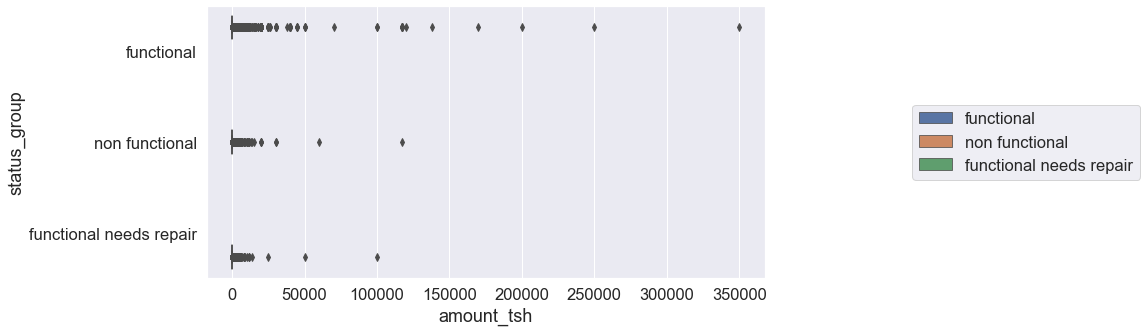

In [471]:
plt.figure(figsize=(10,5))
boxplot = sns.boxplot(x="amount_tsh", y="status_group",data=train_df, width=0.8, hue="status_group")
boxplot.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
print('mean of amount_tsh by',train_df.groupby('status_group')['amount_tsh'].mean())

In [476]:
stats.f_oneway(train_df['amount_tsh'][train_df['status_group'] == 'functional'], 
    train_df['amount_tsh'][train_df['status_group'] == 'non functional'],
    train_df['amount_tsh'][train_df['status_group'] == 'functional needs repair'])

F_onewayResult(statistic=86.04231606614591, pvalue=4.856499407236805e-38)

# gps_height

mean of gps_height by status_group
functional                 1121.235903
functional needs repair    1119.937457
non functional              974.034306
Name: gps_height, dtype: float64


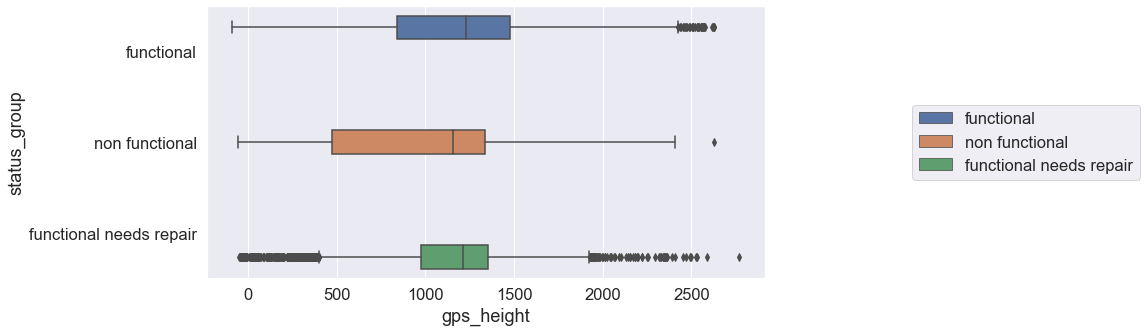

In [484]:
plt.figure(figsize=(10,5))
boxplot = sns.boxplot(x="gps_height", y="status_group",data=train_df, width=0.8, hue="status_group")
boxplot.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
print('mean of gps_height by',train_df.groupby('status_group')['gps_height'].mean())

In [477]:
stats.f_oneway(train_df['gps_height'][train_df['status_group'] == 'functional'], 
    train_df['gps_height'][train_df['status_group'] == 'non functional'],
    train_df['gps_height'][train_df['status_group'] == 'functional needs repair'])

F_onewayResult(statistic=526.8942530113637, pvalue=1.5097424976872923e-227)

# pump_age

mean of pump_age by status_group
functional                 13.245048
functional needs repair    16.509150
non functional             18.214161
Name: pump_age, dtype: float64


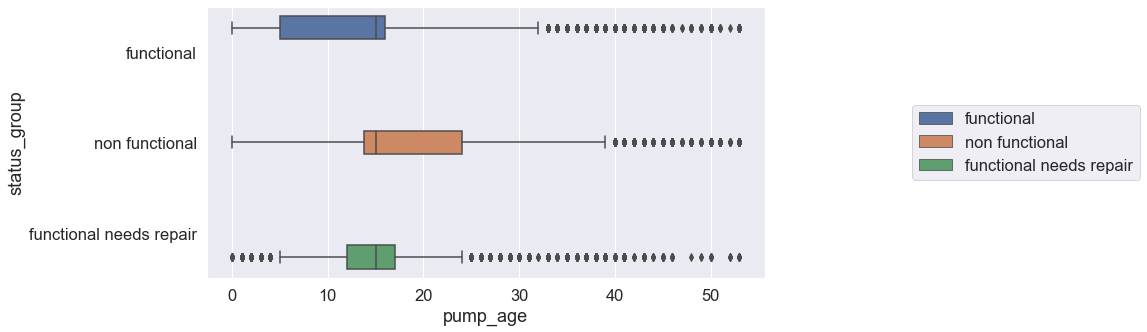

In [483]:
plt.figure(figsize=(10,5))
boxplot = sns.boxplot(x="pump_age", y="status_group",data=train_df, width=0.8, hue="status_group")
boxplot.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
print('mean of pump_age by',train_df.groupby('status_group')['pump_age'].mean())

In [478]:
stats.f_oneway(train_df['pump_age'][train_df['status_group'] == 'functional'], 
    train_df['pump_age'][train_df['status_group'] == 'non functional'],
    train_df['pump_age'][train_df['status_group'] == 'functional needs repair'])

F_onewayResult(statistic=1746.398131585104, pvalue=0.0)

# Load dataset 
https://pytorch-geometric.readthedocs.io/en/latest/notes/create_dataset.html

In [5]:
import numpy as np
import pandas as pd
import pickle
import csv
import os
import torch
from torch.utils.data import Subset

In [6]:
selected_df = pd.read_csv('dataset_imputed.csv')
# selected_df = dataset_imputed.copy()

# Spit Train and Test set after data imputation
train_df = selected_df[:train_len]
test_df = selected_df[train_len:]

# Merge train dataset with train_label
train_df = pd.merge(train_df,train_label,on='id')

# Imbalance dataset

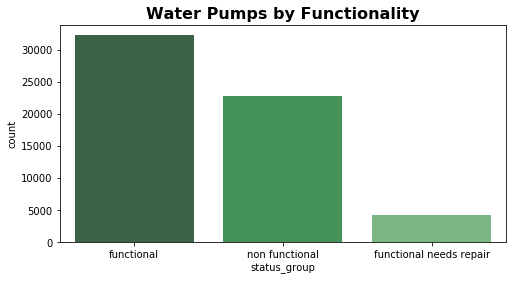

In [7]:
plt.figure(figsize=(8,4))
plt.title("Water Pumps by Functionality",fontsize=16, fontweight='bold')
sns.countplot(x=train_df['status_group'], data=train_df, palette="Greens_d");

In [8]:
train_df['status_group'].value_counts()/59400

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [9]:
# Set random seed at 42
#42 for 9000
np.random.seed(42)

column_ID = 'node_id'
num_sampling = 9000

sub_samping = round(num_sampling/3)
# #randomly sample a couple of them
sampled1 = np.random.choice(train_df.id[train_df.status_group == 'functional'].unique(), sub_samping, replace=False)
sampled2 = np.random.choice(train_df.id[train_df.status_group == 'functional needs repair'].unique(), sub_samping, replace=False)
sampled3 = np.random.choice(train_df.id[train_df.status_group == 'non functional'].unique(), sub_samping, replace=False)

sampled_session_id = np.append(sampled1, sampled2, axis=0)
sampled_session_id = np.append(sampled_session_id, sampled3, axis=0)

In [10]:
random_train_df = train_df.loc[train_df.id.isin(sampled_session_id)]

random_train_df = random_train_df.reset_index(drop=True)
random_train_df['train_mask'] = 0
random_train_df['val_mask'] = 0
random_train_df['test_mask'] = 0
random_train_df = random_train_df.rename(columns={"id": "node_id"})

In [11]:
random_train_df

,node_id,amount_tsh,gps_height,longitude,latitude,num_private,population,pump_age,funder_0,funder_Danida,...,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,status_group,train_mask,val_mask,test_mask
0,49056,0.0,62.0,39.209518,-7.034139,0,345,0,0,0,...,0,0,0,0,0,1,functional,0,0,0
1,34169,0.0,1162.0,32.920154,-1.947868,0,1000,12,0,0,...,0,0,0,0,0,1,functional needs repair,0,0,0
2,58500,0.0,1510.0,34.586901,-8.980014,0,350,33,0,0,...,1,0,0,0,0,0,functional needs repair,0,0,0
3,22308,0.0,1273.0,37.422751,-3.317536,0,140,39,0,0,...,1,0,0,0,0,0,functional needs repair,0,0,0
4,57238,0.0,1481.0,37.492334,-3.290627,0,180,41,0,0,...,0,0,0,0,0,1,functional needs repair,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,8810,0.0,1656.0,34.594790,-9.072904,0,35,33,0,0,...,1,0,0,0,0,0,functional needs repair,0,0,0
8996,47527,0.0,2333.0,33.670049,-9.001535,0,0,15,0,0,...,1,0,0,0,0,0,functional,0,0,0
8997,20387,0.0,1277.0,33.586406,-3.040369,0,0,16,0,0,...,0,0,0,1,0,0,non functional,0,0,0
8998,34473,500.0,1327.0,33.951681,-2.021854,0,200,1,0,0,...,0,0,0,1,0,0,functional,0,0,0


In [12]:
status_group_encoder = LabelEncoder()
random_train_df['status_group'] = status_group_encoder.fit_transform(random_train_df.status_group)

In [13]:
val_split = 0.3
train_idx, val_idx = train_test_split(list(range(len(random_train_df))), test_size=val_split,stratify = random_train_df.status_group)
random_train_df.loc[random_train_df.index.isin(train_idx),'train_mask'] = 1
random_train_df.loc[random_train_df.index.isin(val_idx),'val_mask'] = 1

In [14]:
random_train_df.shape

(9000, 300)

In [15]:
test_df = test_df.rename(columns={"id": "node_id"})

test_df['train_mask'] = 0
test_df['val_mask'] = 0
test_df['test_mask'] = 1
test_df['status_group'] = 0

full_df = random_train_df.append(test_df)
full_df = full_df.reset_index(drop=True)


full_df.node_id = full_df.index
# id_encoder = LabelEncoder()
# full_df['node_id'] = id_encoder.fit_transform(full_df.node_id)

In [16]:
full_df.shape

(23850, 300)

In [17]:
from sklearn import preprocessing

int_col = ['amount_tsh','gps_height','longitude','latitude','num_private','population','pump_age']

full_df_scaled = full_df.copy()

sc = preprocessing.StandardScaler()
full_df_scaled[int_col] = sc.fit_transform(full_df[int_col])

In [18]:
x_df = full_df_scaled.copy()

x_df = x_df.drop('node_id', axis = 1)
x_df = x_df.drop('status_group', axis = 1)
x_df = x_df.drop('train_mask', axis = 1)
x_df = x_df.drop('val_mask', axis = 1)
x_df = x_df.drop('test_mask', axis = 1)

In [19]:
x_df.shape

(23850, 295)

In [20]:
X_train = x_df.iloc[x_df.index.isin(train_idx),:]
X_test = x_df.iloc[x_df.index.isin(val_idx),:]

y_train = full_df.loc[full_df.index.isin(train_idx),'status_group']
y_test = full_df.loc[full_df.index.isin(val_idx),'status_group']

In [21]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Validating Features Shape:', X_test.shape)
print('Validating Labels Shape:', y_test.shape)

Training Features Shape: (6300, 295)
Training Labels Shape: (6300,)
Validating Features Shape: (2700, 295)
Validating Labels Shape: (2700,)


# Result_df

In [22]:
result_df = pd.DataFrame([], columns = ['sampling_size' 
                                        , 'model'
                                        , 'model_config' 
                                        , 'accuracy_score'
                                        , 'classification_report'
                                        , 'confusion_matrix'
                                        , 'note'])

# confusion_matrix

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Decision Tree

In [24]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_true, y_pred = y_test , dtc.predict(X_test)

Results on the test set: DecisionTree
              precision    recall  f1-score   support

           0       0.59      0.60      0.59       900
           1       0.64      0.63      0.63       900
           2       0.67      0.67      0.67       900

    accuracy                           0.63      2700
   macro avg       0.63      0.63      0.63      2700
weighted avg       0.63      0.63      0.63      2700

accuracy_score 0.6311111111111111
Confusion matrix, without normalization


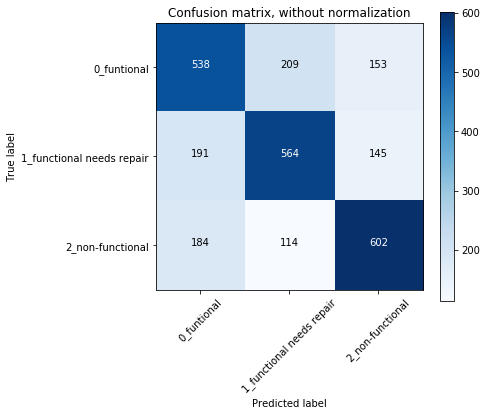

In [25]:
#input
sampling_size = num_sampling
model = 'DecisionTree'
model_config = dtc
acc_score = accuracy_score(y_true, y_pred)
cls_report = classification_report(y_true, y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
note = ''

#save
result_df = result_df.append(pd.Series([sampling_size, model, model_config,acc_score,cls_report,cnf_matrix,note]
                                             , index=result_df.columns ), ignore_index=True)
#Display
print('Results on the test set:',model)
print(cls_report)
print('accuracy_score',acc_score)

plt.figure(figsize = (7,6))
plot_confusion_matrix(cnf_matrix, classes=['0_funtional', '1_functional needs repair', '2_non-functional'],
                      title='Confusion matrix, without normalization')

# random forest

In [26]:
rf = RandomForestClassifier(n_estimators=500, max_depth=500)
rf.fit(X_train, y_train)
y_true,y_pred = y_test, rf.predict(X_test)

Results on the test set: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       900
           1       0.70      0.70      0.70       900
           2       0.74      0.72      0.73       900

    accuracy                           0.70      2700
   macro avg       0.70      0.70      0.70      2700
weighted avg       0.70      0.70      0.70      2700

accuracy_score 0.6955555555555556
Confusion matrix, without normalization


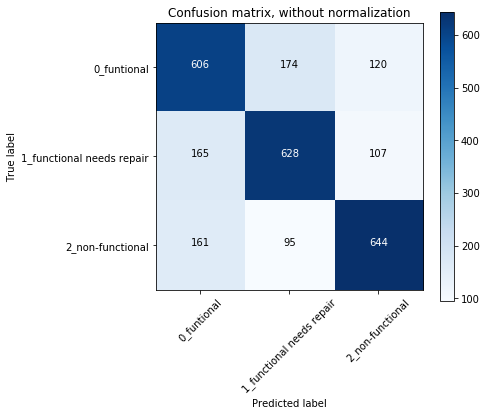

In [27]:
#input
sampling_size = num_sampling
model = 'RandomForestClassifier'
model_config = rf
acc_score = accuracy_score(y_true, y_pred)
cls_report = classification_report(y_true, y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
note = ''

#save
result_df = result_df.append(pd.Series([sampling_size, model, model_config,acc_score,cls_report,cnf_matrix,note]
                                             , index=result_df.columns ), ignore_index=True)
#Display
print('Results on the test set:',model)
print(cls_report)
print('accuracy_score',acc_score)

plt.figure(figsize = (7,6))
plot_confusion_matrix(cnf_matrix, classes=['0_funtional', '1_functional needs repair', '2_non-functional'],
                      title='Confusion matrix, without normalization')

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

feature_list = list(X_train.columns)
feature_importances = pd.DataFrame(rf.feature_importances_,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances['Variable'] = feature_list

In [29]:
feature_importances.head(20)

,importance,Variable
2,0.086250,amount_tsh
3,0.084207,gps_height
1,0.081418,longitude
6,0.047128,latitude
5,0.039469,num_private
268,0.026911,population
273,0.026798,pump_age
0,0.019937,funder_0
294,0.016871,funder_Danida
232,0.015772,funder_Dhv


# GradientBoostingClassifier

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)
y_true, y_pred = y_test , gbc.predict(X_test)

Results on the test set: GradientBoosting
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       900
           1       0.66      0.68      0.67       900
           2       0.77      0.65      0.70       900

    accuracy                           0.67      2700
   macro avg       0.68      0.67      0.67      2700
weighted avg       0.68      0.67      0.67      2700

accuracy_score 0.6681481481481482
Confusion matrix, without normalization


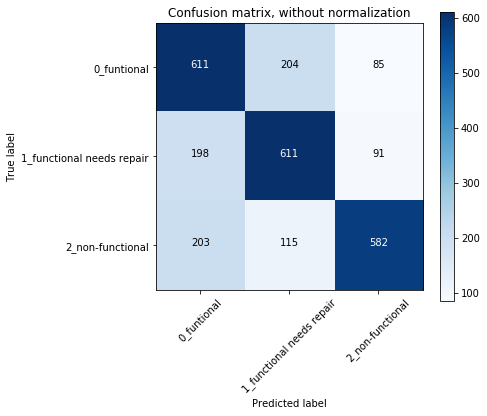

In [31]:
#input
sampling_size = num_sampling
model = 'GradientBoosting'
model_config = gbc
acc_score = accuracy_score(y_true, y_pred)
cls_report = classification_report(y_true, y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
note = ''

#save
result_df = result_df.append(pd.Series([sampling_size, model, model_config,acc_score,cls_report,cnf_matrix,note]
                                             , index=result_df.columns ), ignore_index=True)
#Display
print('Results on the test set:',model)
print(cls_report)
print('accuracy_score',acc_score)

plt.figure(figsize = (7,6))
plot_confusion_matrix(cnf_matrix, classes=['0_funtional', '1_functional needs repair', '2_non-functional'],
                      title='Confusion matrix, without normalization')

# Neural network classification
* https://scikit-learn.org/stable/modules/neural_networks_supervised.html

# NN hyperparameter
* https://datascience.stackexchange.com/questions/36049/how-to-adjust-the-hyperparameters-of-mlp-classifier-to-get-more-perfect-performa
* https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-i-hyper-parameter-8129009f131b
* https://www.heatonresearch.com/2017/06/01/hidden-layers.html

In [32]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

In [33]:
# parameter_space = {
#     'hidden_layer_sizes': [(25,)],
#     'activation': ['logistic', 'relu'],
#     'solver': ['sgd', 'adam','lbfgs'],
# #     'alpha': [0.001,0.01],
# #     'alpha': 10.0 ** -np.arange(1, 5),
# #     'max_iter': [200,500,1000],
# #     'learning_rate': ['adaptive'],
# }

parameter_space = {
    'hidden_layer_sizes': [(25,),(50,)],
    'activation': ['logistic', 'relu'],
    'solver': ['sgd', 'adam'],
    'max_iter': [250,500],
}

In [34]:
%%time
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
gs.fit(X_train, y_train)

CPU times: user 52 s, sys: 7.12 s, total: 59.1 s
Wall time: 1min 49s


/Users/sawit/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [35]:
# Best paramete set
print('Best parameters found:\n', gs.best_params_)

Best parameters found:
 {'activation': 'logistic', 'hidden_layer_sizes': (50,), 'max_iter': 500, 'solver': 'adam'}


In [489]:
y_true, y_pred = y_test , gs.predict(X_test)

Results on the test set: NeuralNetworks
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       900
           1       0.67      0.67      0.67       900
           2       0.72      0.70      0.71       900

    accuracy                           0.67      2700
   macro avg       0.67      0.67      0.67      2700
weighted avg       0.67      0.67      0.67      2700

accuracy_score 0.6744444444444444
Confusion matrix, without normalization


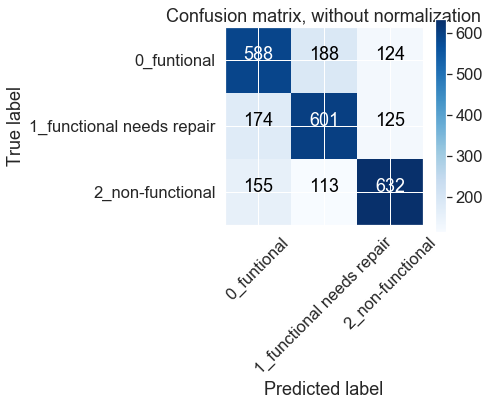

In [490]:
#input
sampling_size = num_sampling
model = 'NeuralNetworks'
model_config = gs
acc_score = accuracy_score(y_true, y_pred)
cls_report = classification_report(y_true, y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
note = ''

#save
result_df = result_df.append(pd.Series([sampling_size, model, model_config,acc_score,cls_report,cnf_matrix,note]
                                             , index=result_df.columns ), ignore_index=True)
#Display
print('Results on the test set:',model)
print(cls_report)
print('accuracy_score',acc_score)

plt.figure(figsize = (7,6))
plot_confusion_matrix(cnf_matrix, classes=['0_funtional', '1_functional needs repair', '2_non-functional'],
                      title='Confusion matrix, without normalization')

# Visualize output

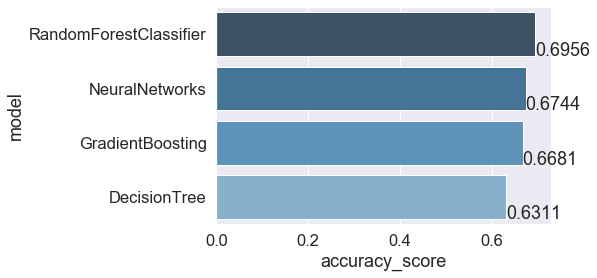

In [39]:
result_df = result_df.sort_values('accuracy_score',ascending=False)

ax = sns.barplot(x="accuracy_score", y="model", data=result_df, palette="Blues_d")

for p in ax.patches:
    percentage ='{:.4f}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width
    y=p.get_y()+height
    ax.annotate(percentage,(x,y))
    
sns.set(font_scale=1.5)

# Graph Convolution Neural Networks (GCNs)

# Create Adjacency matrix

In [43]:
#Adjacency matrix
def create_graph_network(df,column_ID,column_edge,n_filter):
    
    # select columns, remove NaN
    table = df[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() 

    table.index = table[column_ID]
    row = np.array(table[column_edge].astype(int).tolist())
    col = np.array(table[column_edge].astype(int).tolist())
    
    # create (1,N) and (N,1) set for brodcasting  
    row = row.reshape(len(row),1)
    col = col.reshape(1,len(col))
    
    # Brodcasting calculation
    w_matrix = row - col #weights diff
    w_matrix = pd.DataFrame(w_matrix, index = table.index, columns = table.index)
    
    #Prepare to convert data into Pandas format
    sources = []
    targets = []
    weights = []
    for i in tqdm(table[column_ID]):
        for j in table[column_ID]:
            sources.append(i)
            targets.append(j)
            weights.append(w_matrix.loc[i,j]) 
                
    df = pd.DataFrame({'node_id':sources,'node_id_2':targets,'weights':weights})
    df = df.rename(columns={'weights':column_edge})
    
    #Focus only the close assocoation based on the input filter
    df = df[(df[column_edge]>=n_filter*-1)&(df[column_edge]<=n_filter)]
    
    return df

In [44]:
edge_stat = pd.DataFrame([], columns = ['sampling_size' 
                                        , 'edge'
                                        , 'df1' 
                                        , 'df2'
                                        , 'df3'
                                        , 'rand_pct'
                                        , 'df2_'
                                        , 'df3_'
                                        , 'final_df'])

In [45]:
df_graph = full_df[:num_sampling]
df_graph.shape

(9000, 300)

### Build graph network based on amount_tsh

In [115]:
%%time
column_ID = 'node_id'
column_edge = 'amount_tsh'
n_filter = 3
d_amount_tsh = create_graph_network(df_graph,column_ID,column_edge,n_filter)


CPU times: user 11min 9s, sys: 28.6 s, total: 11min 37s
Wall time: 11min 42s


In [557]:
np.random.seed(42)
df = d_amount_tsh 
r_pct = [0.0001, 0.1]
# r_pct = [0,0]
column_edge = 'amount_tsh' # 'amount_tsh','gps_height','num_private','population','pump_age'
n_filter= 3

#Self-edge
df1 = df[df.node_id == df.node_id_2] 
#Same association with other node
df2 = df[(df.node_id != df.node_id_2) & (df[column_edge] == 0)]
#Close association with other node but less than filter criteria 
df3 = df[df[column_edge] > 0]

rand2 = np.random.choice(df2.index, round(len(df2)*r_pct[0]), replace=False)
random_df2 = df2.loc[df2.index.isin(rand2)]

rand3 = np.random.choice(df3.index, round(len(df3)*r_pct[1]), replace=False)
random_df3 = df3.loc[df3.index.isin(rand3)]

frames = [df1, random_df2,random_df3]
df = pd.concat(frames)    
df = df.reset_index(drop=True)

d = df
g_stat = pd.Series([num_sampling,column_edge, len(df1), len(df2),len(df3)
                    ,r_pct,len(random_df2),len(random_df3),len(df)], index=edge_stat.columns)
print(g_stat)

sampling_size             9000
edge                amount_tsh
df1                       9000
df2                   42455188
df3                      21311
rand_pct         [0.0001, 0.1]
df2_                      4246
df3_                      2131
final_df                 15377
dtype: object


### Build graph network based on gps_height

In [239]:
%%time
column_ID = 'node_id' #:Id 1
column_edge = 'gps_height' # 'amount_tsh','gps_height','num_private','population','pump_age'
n_filter = 5
d_gps_height = create_graph_network(df_graph,column_ID,column_edge,n_filter)


CPU times: user 10min 56s, sys: 24.6 s, total: 11min 21s
Wall time: 11min 25s


In [522]:
np.random.seed(42)
df = d_gps_height 
r_pct = [0,0]
column_edge = 'gps_height' # 'amount_tsh','gps_height','num_private','population','pump_age'
n_filter= 5

#Self-edge
df1 = df[df.node_id == df.node_id_2] 
#Same association with other node
df2 = df[(df.node_id != df.node_id_2) & (df[column_edge] == 0)]
#Close association with other node but less than filter criteria 
df3 = df[df[column_edge] > 0]

rand2 = np.random.choice(df2.index, round(len(df2)*r_pct[0]), replace=False)
random_df2 = df2.loc[df2.index.isin(rand2)]

rand3 = np.random.choice(df3.index, round(len(df3)*r_pct[1]), replace=False)
random_df3 = df3.loc[df3.index.isin(rand3)]

frames = [df1, random_df2,random_df3]
df = pd.concat(frames)    
df = df.reset_index(drop=True)

d = df
g_stat = pd.Series([num_sampling,column_edge, len(df1), len(df2),len(df3)
                    ,r_pct,len(random_df2),len(random_df3),len(df)], index=edge_stat.columns)
print(g_stat)

sampling_size          9000
edge             gps_height
df1                    9000
df2                  178266
df3                  305983
rand_pct             [0, 0]
df2_                      0
df3_                      0
final_df               9000
dtype: object


### Build graph network based on pump_age

In [340]:
%%time
column_ID = 'node_id' #:Id 1
column_edge = 'pump_age' # 'amount_tsh','gps_height','num_private','population','pump_age'
n_filter = 3
d_age = create_graph_network(df_graph,column_ID,column_edge,n_filter)


CPU times: user 10min 18s, sys: 19.9 s, total: 10min 38s
Wall time: 10min 36s


In [369]:
np.random.seed(42)
df = d_age 
r_pct = [0.005,0.005]
column_edge = 'pump_age' # 'amount_tsh','gps_height','num_private','population','pump_age'
n_filter= 3

#Self-edge
df1 = df[df.node_id == df.node_id_2] 
#Same association with other node
df2 = df[(df.node_id != df.node_id_2) & (df[column_edge] == 0)]
#Close association with other node but less than filter criteria 
df3 = df[df[column_edge] > 0]

rand2 = np.random.choice(df2.index, round(len(df2)*r_pct[0]), replace=False)
random_df2 = df2.loc[df2.index.isin(rand2)]

rand3 = np.random.choice(df3.index, round(len(df3)*r_pct[1]), replace=False)
random_df3 = df3.loc[df3.index.isin(rand3)]

frames = [df1, random_df2,random_df3]
df = pd.concat(frames)    
df = df.reset_index(drop=True)

d = df
g_stat = pd.Series([num_sampling,column_edge, len(df1), len(df2),len(df3)
                    ,r_pct,len(random_df2),len(random_df3),len(df)], index=edge_stat.columns)
print(g_stat)

sampling_size              9000
edge                   pump_age
df1                        9000
df2                     7357754
df3                     8099016
rand_pct         [0.005, 0.005]
df2_                      36789
df3_                      40495
final_df                  86284
dtype: object


In [556]:
df

,node_id,node_id_2,gps_height
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,0
...,...,...,...
8995,8995,8995,0
8996,8996,8996,0
8997,8997,8997,0
8998,8998,8998,0


# GCNs modelling part

In [523]:
xx_df = df_graph.copy()

xx_df = xx_df.drop('node_id', axis = 1)
xx_df = xx_df.drop('status_group', axis = 1)
xx_df = xx_df.drop('train_mask', axis = 1)
xx_df = xx_df.drop('val_mask', axis = 1)
xx_df = xx_df.drop('test_mask', axis = 1)

In [524]:
import torch
from torch_geometric.data import Data

x = torch.LongTensor(xx_df.values)
y = torch.tensor(df_graph.loc[:,'status_group'].values, dtype=torch.long)

train_mask = torch.tensor(df_graph.loc[:,'train_mask'].values, dtype=torch.bool)
val_mask = torch.tensor(df_graph.loc[:,'val_mask'].values, dtype=torch.bool)
test_mask = torch.tensor(df_graph.loc[:,'test_mask'].values, dtype=torch.bool)

edge_index = torch.LongTensor(d[['node_id','node_id_2']].values)

data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)

In [525]:
data

Data(edge_index=[2, 9000], test_mask=[9000], train_mask=[9000], val_mask=[9000], x=[9000, 295], y=[9000])

In [ ]:
edge_index

# Visualization (can skip since it might take some time for many nodes)

In [526]:
%%time
import networkx as nx

nx_graph = nx.from_pandas_edgelist(df=d, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)
node_labels = df_graph['status_group'].to_numpy()

CPU times: user 31.4 ms, sys: 1.33 ms, total: 32.8 ms
Wall time: 32 ms


In [554]:
nx_graph

In [527]:
nx.info(nx_graph)

'Name: \nType: Graph\nNumber of nodes: 9000\nNumber of edges: 9000\nAverage degree:   2.0000'

### can skip this part

# Model

In [528]:
def df_info(data):
    print(data.keys)
    print('num_nodes:',data.num_nodes)
    print('num_edges:',data.num_edges)
    print('num_node_features:',data.num_node_features)
    print('contains_isolated_nodes:',data.contains_isolated_nodes())
    print('contains_self_loops:',data.contains_self_loops())
    print('is_directed:',data.is_directed())

df_info(data)

['x', 'edge_index', 'y', 'train_mask', 'val_mask', 'test_mask']
num_nodes: 9000
num_edges: 9000
num_node_features: 295
contains_isolated_nodes: True
contains_self_loops: True
is_directed: False


In [529]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

#define the input variable
x = torch.LongTensor(xx_df.values)
y = torch.tensor(df_graph.loc[:,'status_group'].values, dtype=torch.long)
train_mask = torch.tensor(df_graph.loc[:,'train_mask'].values, dtype=torch.bool)
val_mask = torch.tensor(df_graph.loc[:,'val_mask'].values, dtype=torch.bool)
test_mask = torch.tensor(df_graph.loc[:,'test_mask'].values, dtype=torch.bool)
edge_index = torch.LongTensor(d[['node_id','node_id_2']].values)
data = Data(x=x, edge_index=edge_index.t().contiguous(), y=y, train_mask=train_mask,val_mask=val_mask,test_mask=test_mask)

learning_rate = 0.001
col1 = []
col2 = []
col3 = []
num_epoch = 300

#Create the stucture of GCNs
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 50)
        self.conv2 = GCNConv(50, 3)
        
    def forward(self, data):
        x  = data.x.float()
        edge_index = data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def evaluate(data,filter_mask):
    model.eval()
    _, pred = model(data).max(dim=1)
    y_pred = pred[data[filter_mask]]
    y_true = data.y[data[filter_mask]]
    acc =  accuracy_score(y_true, y_pred)         
    return acc    

In [530]:
%%time
# https://pytorch.org/docs/stable/optim.html

opt = 'Rprop'
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.ASGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Adam,Adamx,Adadelta,Adagrad,AdamW,ASGD,LBFGS,RMSprop,Rprop,SGD
#SparseAdam,LBFGS

CPU times: user 1.32 ms, sys: 751 µs, total: 2.08 ms
Wall time: 1.35 ms


In [531]:
def train():
    model.train()

    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

def evaluate(data,filter_mask):
    model.eval()
    _, pred = model(data).max(dim=1)
    y_pred = pred[data[filter_mask]]
    y_true = data.y[data[filter_mask]]
    acc =  accuracy_score(y_true, y_pred)         

    return acc

In [532]:
%%time
model.train()

col1 = []
col2 = []
col3 = []

num_epoch = 300

for epoch in tqdm(range(num_epoch)):
    loss = train()
    train_acc = evaluate(data,'train_mask')
    test_acc = evaluate(data,'val_mask')
    
    col1.append(loss)
    col2.append(train_acc)
    col3.append(test_acc)


CPU times: user 1min 29s, sys: 2.21 s, total: 1min 32s
Wall time: 14 s


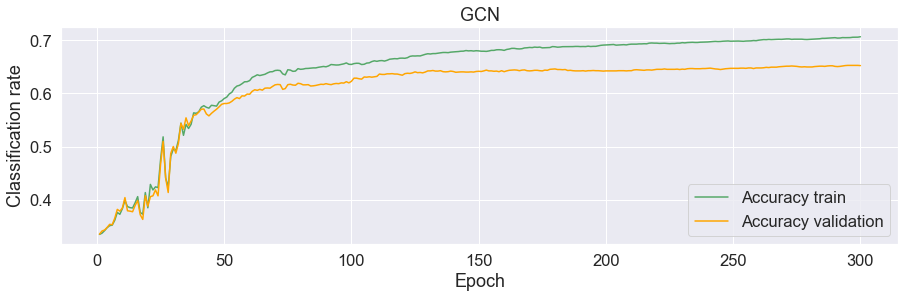

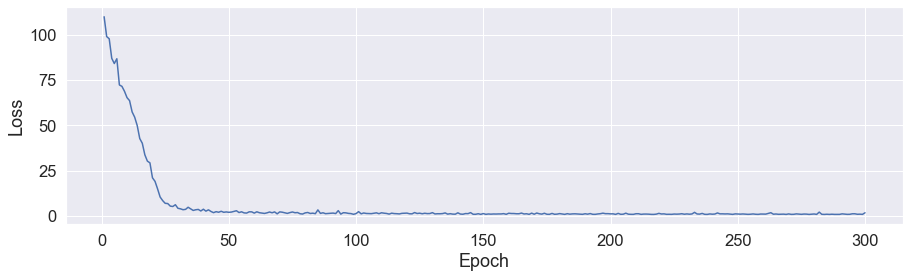

In [533]:
gcn_stat = pd.DataFrame({'loss':col1,'train_Accuracy':col2,'test_Accuracy':col3})
gcn_stat.index = np.arange(1, len(gcn_stat) + 1)

plt.figure(figsize = (15,4))
# plt.plot(gcn_stat.index, gcn_stat.loss, color='b',label='loss')
plt.plot(gcn_stat.index, gcn_stat.train_Accuracy, color='g',label='Accuracy train')
plt.plot(gcn_stat.index, gcn_stat.test_Accuracy, color='orange',label='Accuracy validation')
plt.xlabel('Epoch')
plt.ylabel('Classification rate')
plt.title('GCN')
leg = plt.legend();
sns.set(font_scale=1.5)
plt.show()

plt.figure(figsize = (15,4))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(gcn_stat.index, gcn_stat.loss, color='b',label='loss')
plt.show()

In [534]:
#https://skorch.readthedocs.io/en/stable/user/quickstart.html
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [535]:
_, pred = model(data).max(dim=1)

y_pred = pred[data['val_mask']]
y_true = data.y[data['val_mask']]

acc =  accuracy_score(y_true, y_pred)         
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())  

In [536]:
notes_gcn = {
    'num_epoch' : num_epoch,
    'optimizer' : optimizer,
    'learning' : learning_rate,
    'last_loss' : loss.item(),
    'graphinfo': nx.info(nx_graph),
    'edge_stat' : g_stat

}
print(notes_gcn)

{'num_epoch': 300, 'optimizer': Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.001
    step_sizes: (1e-06, 50)
), 'learning': 0.001, 'last_loss': 1.6871393918991089, 'graphinfo': 'Name: \nType: Graph\nNumber of nodes: 9000\nNumber of edges: 9000\nAverage degree:   2.0000', 'edge_stat': sampling_size          9000
edge             gps_height
df1                    9000
df2                  178266
df3                  305983
rand_pct             [0, 0]
df2_                      0
df3_                      0
final_df               9000
dtype: object}


Results on the test set: GCN_selfedges
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       900
           1       0.60      0.73      0.66       900
           2       0.75      0.62      0.68       900

    accuracy                           0.65      2700
   macro avg       0.66      0.65      0.65      2700
weighted avg       0.66      0.65      0.65      2700

accuracy_score 0.6525925925925926
Confusion matrix, without normalization


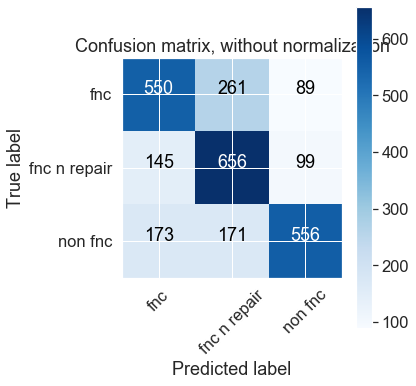

In [537]:
#input
sampling_size = num_sampling
# model_name = 'GCN_' + column_edge + '_' +str(n_filter) + '_' + opt + '_' + str(learning_rate) + '_' + str(r_pct)
# model_name = 'GCN_' + opt + '_' + str(learning_rate)
# model_name = 'GCN_' + column_edge + '_' +str(n_filter) + '_' + str(r_pct)
model_name = 'GCN_selfedges'

model_config = model
acc_score = accuracy_score(y_true, y_pred)
cls_report = classification_report(y_true, y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
note = notes_gcn

#save
result_df = result_df.append(pd.Series([sampling_size, model_name, model_config,acc_score,cls_report,cnf_matrix,note]
                                             , index=result_df.columns ), ignore_index=True)
#Display
print('Results on the test set:',model_name)
print(cls_report)
print('accuracy_score',acc_score)

plt.figure(figsize = (6,6))
plot_confusion_matrix(cnf_matrix, classes=['fnc', 'fnc n repair', 'non fnc'],
                      title='Confusion matrix, without normalization')

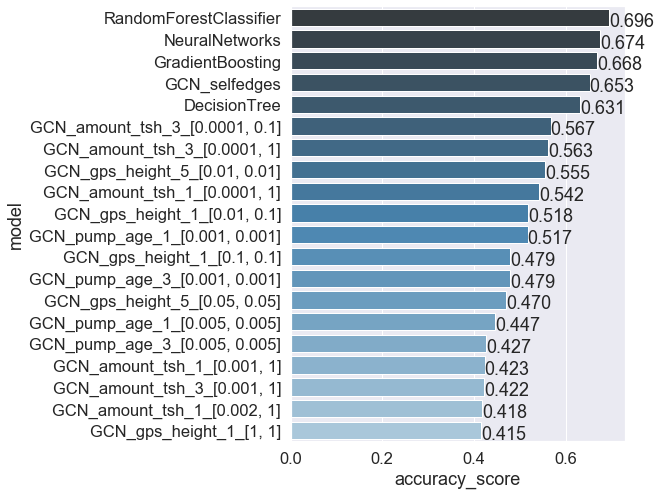

In [548]:
result_df = result_df.sort_values('accuracy_score',ascending=False)


result_df_vis = result_df

plt.figure(figsize = (6,8))
ax = sns.barplot(x="accuracy_score", y="model", data=result_df_vis, palette="Blues_d")

for p in ax.patches:
    percentage ='{:.3f}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width
    y=p.get_y()+height
    ax.annotate(percentage,(x,y))
    
sns.set(font_scale=1.5)

In [547]:
result_df

,sampling_size,model,model_config,accuracy_score,classification_report,confusion_matrix,note
0,9000,RandomForestClassifier,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.695556,precision recall f1-score ...,"[[606, 174, 120], [165, 628, 107], [161, 95, 6...",
1,9000,NeuralNetworks,"GridSearchCV(cv=3, error_score=nan,\n ...",0.674444,precision recall f1-score ...,"[[588, 188, 124], [174, 601, 125], [155, 113, ...",
3,9000,GradientBoosting,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri...",0.668148,precision recall f1-score ...,"[[611, 204, 85], [198, 611, 91], [203, 115, 582]]",
23,9000,GCN_selfedges,"Net(\n (conv1): GCNConv(295, 50)\n (conv2): ...",0.652593,precision recall f1-score ...,"[[550, 261, 89], [145, 656, 99], [173, 171, 556]]","{'num_epoch': 300, 'optimizer': Rprop ( Parame..."
7,9000,DecisionTree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.631111,precision recall f1-score ...,"[[538, 209, 153], [191, 564, 145], [184, 114, ...",
8,9000,"GCN_amount_tsh_3_[0.0001, 0.1]","Net(\n (conv1): GCNConv(295, 50)\n (conv2): ...",0.567407,precision recall f1-score ...,"[[408, 325, 167], [150, 610, 140], [129, 257, ...","{'num_epoch': 300, 'optimizer': Rprop ( Parame..."
9,9000,"GCN_amount_tsh_3_[0.0001, 1]","Net(\n (conv1): GCNConv(295, 50)\n (conv2): ...",0.562593,precision recall f1-score ...,"[[417, 231, 252], [165, 534, 201], [153, 179, ...","{'num_epoch': 300, 'optimizer': Rprop ( Parame..."
10,9000,"GCN_gps_height_5_[0.01, 0.01]","Net(\n (conv1): GCNConv(295, 50)\n (conv2): ...",0.555185,precision recall f1-score ...,"[[336, 404, 160], [90, 683, 127], [122, 298, 4...","{'num_epoch': 300, 'optimizer': Rprop ( Parame..."
11,9000,"GCN_amount_tsh_1_[0.0001, 1]","Net(\n (conv1): GCNConv(295, 50)\n (conv2): ...",0.541852,precision recall f1-score ...,"[[405, 343, 152], [158, 617, 125], [138, 321, ...","{'num_epoch': 300, 'optimizer': Rprop ( Parame..."
12,9000,"GCN_gps_height_1_[0.01, 0.1]","Net(\n (conv1): GCNConv(295, 50)\n (conv2): ...",0.517778,precision recall f1-score ...,"[[357, 399, 144], [158, 620, 122], [149, 330, ...","{'num_epoch': 300, 'optimizer': Rprop ( Parame..."
